In [1]:
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

In [2]:
## some necessary linear algebra functions

def vector_len(a: np.ndarray): 
    # calculate the length of a vector by calculating the square root of its self dot product
    
    return np.sqrt(np.dot(a, a))

def vector_angle(a: np.ndarray, b: np.ndarray, output_type = 'radians'): 
    # calculate the angle between two vectors
    
    dotab = np.dot(a,b)
    lena = vector_len(a)
    lenb = vector_len(b)
    prodab = lena*lenb
    
    # theta is the arccosine of the dotproduct of a & b
    # over the product of the lengths of a & b
    theta = np.arccos(dotab/prodab)
    
    output = {
        'radians': theta,
        'degrees': np.degrees(theta)
    }
    
    if output_type not in list(output.keys()):
        print("Error: please specify an output type of either 'radians' or 'degrees'")
    
    return output[output_type]

In [3]:
## Load the V1 PCA data

v1_xs_file = os.path.join("project_datafiles", "v1_ori_phase_condition_pcascores_wcomp.pkl")
v1_scores = pd.read_pickle(v1_xs_file)
v1_scores_condition_averaged = np.array([np.array(x) for x in v1_scores.scores.values]).mean(0)

## Neuronal response profiles

- In a population of neurons, there exist groups of neurons with covarying activity. To simplify the analysis of these groups, it is useful to implement dimensionality reduction methods such as principal component analysis (PCA). 
- In the plot below, the activity of the primary visual cortex (V1) population in response to two stimuli with different spatial frequency (SF) is projected onto the first two principal components (PCs) of the data.
- We can consider the response profile of each PC to represent a unique group of units in the V1 population with covarying activity, likely stemming from the aggregated activity of a unique circuit motif.

Text(0.5, 0, 'Time (ms)')

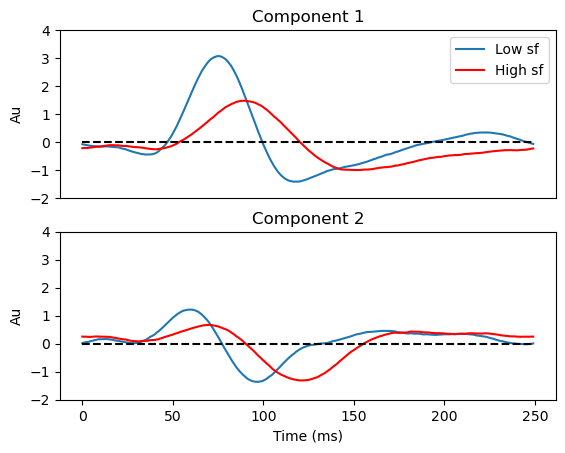

In [4]:
fig, ax = plt.subplots(2)

ax[0].plot(v1_scores_condition_averaged[0,:,0], label = 'Low sf')
ax[0].plot(v1_scores_condition_averaged[0,:,-1], color = 'red', label = 'High sf')
ax[0].set_title("Component 1")
ax[0].legend()
ax[0].set_xticks([])

ax[1].plot(v1_scores_condition_averaged[1,:,0])
ax[1].plot(v1_scores_condition_averaged[1,:,-1], color = 'red')
ax[1].set_title('Component 2')
for i in range(2):
    ax[i].set_ylabel("Au")
    ax[i].plot(np.zeros(250), '--', color = 'black')
    ax[i].set_ylim(-2,4)

ax[1].set_xlabel("Time (ms)")

## Decorrelation of SF vectors

- As described in Elsayed (2025), the spatial frequency vectors defined by the V1 population are initially highly colinear and then decorrelated with increasing response lag. Using PCA enables us to visualize this because we can treat the population state space as two-dimensional:

In [5]:
## calculate the angle and dot product between SF vectors at each time bin
ang = []
dotprod = []
for t in range(250):
    ang.append(
        vector_angle(
            [v1_scores_condition_averaged[0,:,0][t], v1_scores_condition_averaged[1,:,0][t]],
            [v1_scores_condition_averaged[0,:,-1][t], v1_scores_condition_averaged[1,:,-1][t]],
            output_type = 'degrees'
        )
    )

    dotprod.append(
        np.dot(
            [v1_scores_condition_averaged[0,:,0][t], v1_scores_condition_averaged[1,:,0][t]],
            [v1_scores_condition_averaged[0,:,-1][t], v1_scores_condition_averaged[1,:,-1][t]],
        )
    )
ang = np.array(ang)
dotprod = np.array(dotprod)

In [6]:
t0 = np.where(dotprod[50:] == dotprod[50:].max())[0][0] + 50
t1 = np.where(ang[t0:150] == ang[t0:150]. max())[0][0] + t0

Text(0, 0.5, 'Component 2')

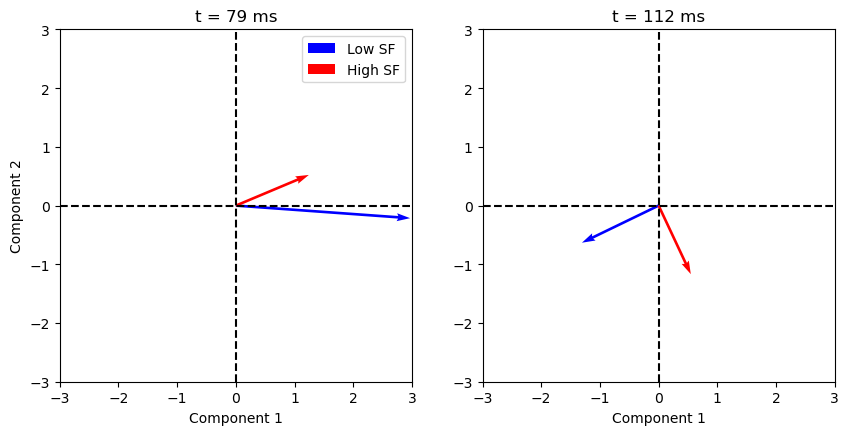

In [7]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

scale = 1
timepoints = [t0,t1]
for i, t in enumerate(timepoints):
    ax[i].quiver(
        0,0, 
        *v1_scores_condition_averaged[:2, t, 0], 
        angles = 'xy',
        scale_units = 'xy',
        scale = scale, color = 'blue',
        label = 'Low SF'
    )
    ax[i].quiver(
        0,0, 
        *v1_scores_condition_averaged[:2, t, -1], 
        angles = 'xy',
        scale_units = 'xy',
        scale = scale, color = 'red',
        label = 'High SF'
    )
    ax[i].plot([0]*250, np.linspace(-3, 3, 250), '--', color = 'black')
    ax[i].plot(np.linspace(-3, 3, 250), [0]*250, '--', color = 'black')
    ax[i].set_ylim(-3,3)
    ax[i].set_xlim(-3,3)
    ax[i].set_aspect('equal')
    ax[i].set_title(f"t = {t} ms")
    ax[i].set_xlabel('Component 1')

ax[0].legend()
ax[0].set_ylabel('Component 2')

# 

## The temporal dynamics of the response profiles explain the early phase colinearity and late phase decorrelation.

- The moment of peak decorrelation (t = 112 ms) can be explained by the following observations:

        a. Both components are coarse-to-fine. IE: there is a time delay between the low SF response and high SF response.

        b. Both components are biphasic, progressing from suprabaseline (enhancement) to sub-baseline (suppression).

        c. The response latencies of each component are temporally distinct. Component 1 is earlier than component 2 overall.

- In each component, low and high SF are slightly temporally out of phase. Therefore each component has moments where low SF and high SF are both above the baseline, both below the baseline, or on opposite sides of the baseline. 

- Decorrelation happens when low and high SF are on opposite sides of the baseline in one component and are on the same side of the baseline in another component at the same time. 

- The Decorrelation is stronger if low and high SF vectors in each component have similar magnitudes/lengths.  

- The temporal characteristics of this neural system are tuned such all of these conditions are nearly perfectly satisfied, as shown below:

Text(0.5, 0, 'Time (ms)')

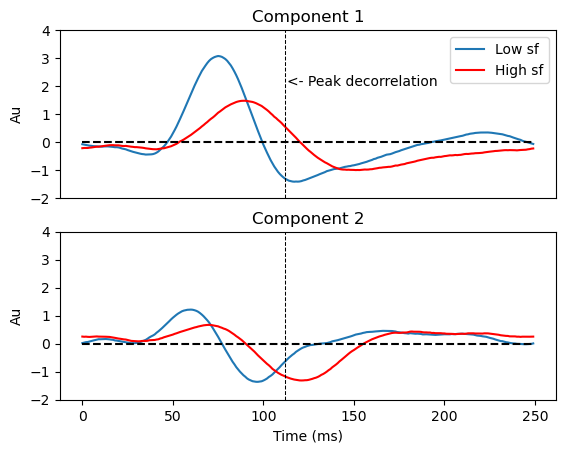

In [8]:
fig, ax = plt.subplots(2)

ax[0].plot(v1_scores_condition_averaged[0,:,0], label = 'Low sf')
ax[0].plot(v1_scores_condition_averaged[0,:,-1], color = 'red', label = 'High sf')
ax[0].plot([t1]*250, np.linspace(-2,4,250), '--', color = 'black', linewidth = 0.75)
ax[0].text(t1+1, 2, "<- Peak decorrelation")
ax[0].set_title("Component 1")
ax[0].legend()
ax[0].set_xticks([])

ax[1].plot(v1_scores_condition_averaged[1,:,0])
ax[1].plot(v1_scores_condition_averaged[1,:,-1], color = 'red')
ax[1].plot([t1]*250, np.linspace(-2,4,250), '--', color = 'black', linewidth = 0.75)
ax[1].set_title('Component 2')
for i in range(2):
    ax[i].set_ylabel("Au")
    ax[i].plot(np.zeros(250), '--', color = 'black')
    ax[i].set_ylim(-2,4)

ax[1].set_xlabel("Time (ms)")

- In the plots below, I demonstrate that any hypothetical response trajectory satisfying the afformentioned conditions will produce decorrelation. If the temporal characteristics of the response are tuned appropriately, multiple moments of decorrelation are possible.

In [9]:
def gaussian( 
    support, # domain of the function
    ctr, # mean of the function
    amp, # amplitude of the function
    mid, # midline of the function
    std # bandwidth parameter
):

    f = np.exp(-1*(((support-ctr)**2)/(2*std**2)))

    return mid+(amp*f)

In [10]:
e1 = gaussian(
    np.linspace(0,250,250),
    70, 1, 0, 20
)

s1 = gaussian(
    np.linspace(0,250,250),
    100, 1, 0, 20
)

e2 = gaussian(
    np.linspace(0,250,250),
    90, 1, 0, 20
)

s2 = gaussian(
    np.linspace(0,250,250),
    120, 1, 0, 20
)

low_sf_1 = e1-s1
high_sf_1 = e2-s2

In [11]:
e3 = gaussian(
    np.linspace(0,250,250),
    45, 1, 0, 20
)

s3 = gaussian(
    np.linspace(0,250,250),
    75, 1, 0, 20
)

e4 = gaussian(
    np.linspace(0,250,250),
    65, 1, 0, 20
)

s4 = gaussian(
    np.linspace(0,250,250),
    95, 1, 0, 20
)

low_sf_2 = e3-s3
high_sf_2 = e4-s4

In [12]:
ang = []
dotprod = []
for t in range(250):
    ang.append(
        vector_angle(
            [low_sf_1[t], low_sf_2[t]],
            [high_sf_1[t], high_sf_2[t]],
            output_type = 'degrees'
        )
    )

    dotprod.append(
        np.dot(
            [low_sf_1[t], low_sf_2[t]],
            [high_sf_1[t], high_sf_2[t]],
        )
    )

ang = np.array(ang)
dotprod = np.array(dotprod)

In [13]:
t0 = np.where(ang[:80] == ang[:80].max())[0][0]
t1 = np.where(ang[80:] == ang[80:].max())[0][0] + 80

Text(0, 0.5, 'Au')

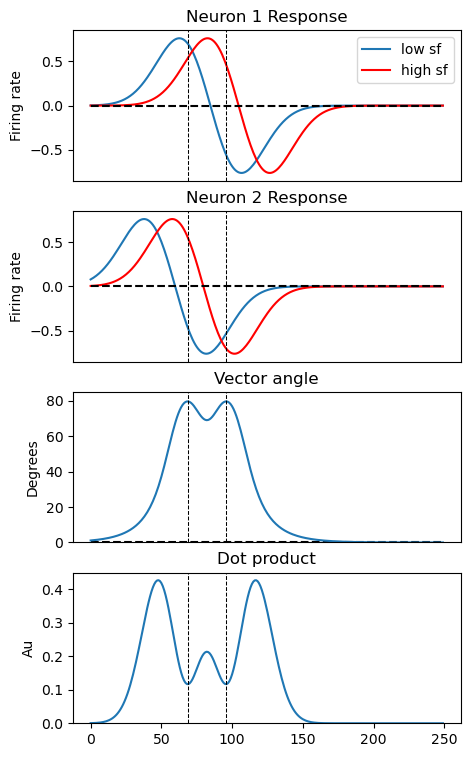

In [14]:
fig, ax = plt.subplots(4, figsize = (5,9))
ax[0].plot(low_sf_1, label = 'low sf')
ax[0].plot(high_sf_1, color = 'red', label = 'high sf')
ax[0].plot([t0]*250, np.linspace(-0.85,0.85,250), '--', color = 'black', linewidth = 0.75)
ax[0].plot([t1]*250, np.linspace(-0.85,0.85,250), '--', color = 'black', linewidth = 0.75)
ax[0].set_ylim(-0.85, 0.85)
ax[0].set_title("Neuron 1 Response")
ax[0].set_ylabel("Firing rate")
ax[0].legend()


ax[1].plot(low_sf_2)
ax[1].plot(high_sf_2, color = 'red')
ax[1].plot([t0]*250, np.linspace(-0.85,0.85,250), '--', color = 'black', linewidth = 0.75)
ax[1].plot([t1]*250, np.linspace(-0.85,0.85,250), '--', color = 'black', linewidth = 0.75)
ax[1].set_ylim(-0.85, 0.85)
ax[1].set_title("Neuron 2 Response")
ax[1].set_ylabel("Firing rate")


for i in range(3):
    ax[i].plot(np.zeros(250), '--', color = 'black')
    if i < 3:
        ax[i].set_xticks([])

ax[2].plot(ang)
ax[2].plot([t0]*250, np.linspace(0,85,250), '--', color = 'black', linewidth = 0.75)
ax[2].plot([t1]*250, np.linspace(0,85,250), '--', color = 'black', linewidth = 0.75)
ax[2].set_ylim(0, 85)
ax[2].set_title("Vector angle")
ax[2].set_ylabel("Degrees")

ax[3].plot(dotprod)
ax[3].plot([t0]*250, np.linspace(0,0.45,250), '--', color = 'black', linewidth = 0.75)
ax[3].plot([t1]*250, np.linspace(0,0.45,250), '--', color = 'black', linewidth = 0.75)
ax[3].set_ylim(0, 0.45)
ax[3].set_title("Dot product")
ax[3].set_ylabel("Au")

Text(0, 0.5, 'Component 2')

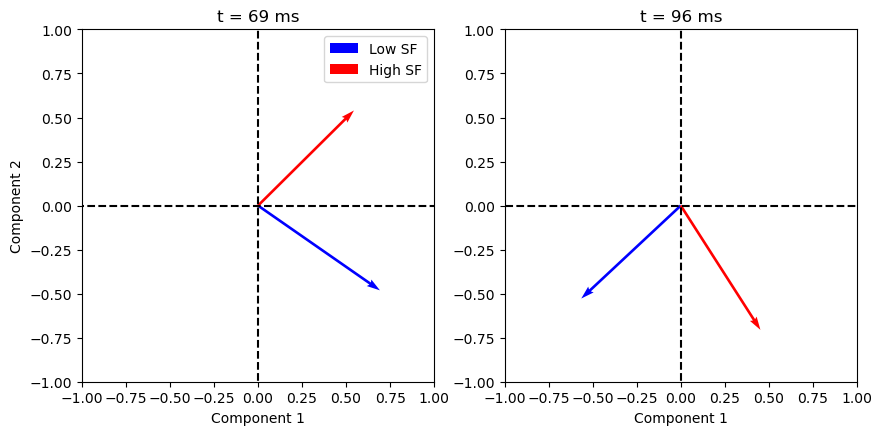

In [15]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

v_l_v1 = np.array([low_sf_1[t], low_sf_2[t]])
v_h_v1 = np.array([high_sf_1[t], high_sf_2[t]])

scale = 1
timepoints = [t0,t1]
for i, t in enumerate(timepoints):
    ax[i].quiver(
        0,0, 
        *np.array([low_sf_1[t], low_sf_2[t]]), 
        angles = 'xy',
        scale_units = 'xy',
        scale = scale, color = 'blue',
        label = 'Low SF'
    )
    ax[i].quiver(
        0,0, 
        *np.array([high_sf_1[t], high_sf_2[t]]), 
        angles = 'xy',
        scale_units = 'xy',
        scale = scale, color = 'red',
        label = 'High SF'
    )
    ax[i].plot([0]*250, np.linspace(-3, 3, 250), '--', color = 'black')
    ax[i].plot(np.linspace(-3, 3, 250), [0]*250, '--', color = 'black')
    ax[i].set_ylim(-1,1)
    ax[i].set_xlim(-1,1)
    ax[i].set_aspect('equal')
    ax[i].set_title(f"t = {t} ms")
    ax[i].set_xlabel('Component 1')

ax[0].legend()
ax[0].set_ylabel('Component 2')

# 